In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, Aer
from qiskit_algorithms.optimizers import COBYLA
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit.circuit import ParameterVector

In [2]:
# Load X data of dimension Nv x 3
import pandas as pd
v = pd.read_csv('hits_and_tracks_3d_events_all.csv', sep=';')
print("features data loaded...")

features data loaded...


In [3]:
#Show the data set
v.head(3)

,event_id,sub_detector_id,sub_detector_type,track_id,track_type,radial_const,azimuthal_const,pitch_const,radial_coeff,azimuthal_coeff,pitch_coeff,hit_id,hit_r,hit_theta,hit_z
0,0,1,short_strip,0,helical_expanding,0.040474,1.797689,0.005237,0.250489,-1,-0.718796,0,0.747227,5.284354,-1.983446
1,0,3,short_strip,0,helical_expanding,0.040474,1.797689,0.005237,0.250489,-1,-0.718796,1,1.077888,3.871574,-2.997883
2,0,5,short_strip,0,helical_expanding,0.040474,1.797689,0.005237,0.250489,-1,-0.718796,2,1.436187,2.486336,-3.979522


In [7]:
#Prepare a set of X data
Xs=[]
#Length of a graph
cut=4
#Number of training samples
n_samples=100
for i in range(n_samples):
    #Focus on event_id=i
    rows_with_event_id_zero = v[v['event_id'] == i]
    #Extract coordinates and label with hit_id in time-order
    new_df=rows_with_event_id_zero[['hit_id','hit_r','hit_theta','hit_z']]
    new_df.set_index('hit_id',inplace=True)
    #Convert to x, y, z coordinates
    new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
    new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])
    new_df=new_df[['hit_x','hit_y','hit_z']]
    # Flatten data
    raw_data=new_df[:cut].values
    X=raw_data.flatten()
    Xs.append(X)

<ipython-input-7-93df26007c5d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_x']=new_df['hit_r']*np.sin(new_df['hit_theta'])
<ipython-input-7-93df26007c5d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['hit_y']=new_df['hit_r']*np.cos(new_df['hit_theta'])
<ipython-input-7-93df26007c5d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [5]:
#Reduced adjacency matrix A
cut=4
#A[i][j]==1 implies there is an edge between i, j-th nodes.
A=[[0 for _ in range(cut)] for _ in range(cut)]
#Collect edges with its end in the "cut" bound
A[0][1]=1
A[1][2]=1
A[2][3]=1
A[1][3]=1
print("Adjacency matrix prepared...")

Adjacency matrix prepared...


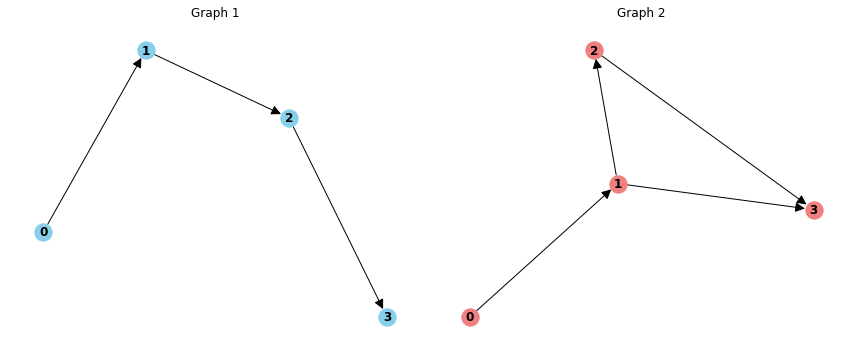

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Define different adjacency matrices
adjacency_matrix_1 = [
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
]

adjacency_matrix_2 = [
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 0]
]

adjacency_matrix_1 = np.array(adjacency_matrix_1)
adjacency_matrix_2 = np.array(adjacency_matrix_2)
# Create graphs from adjacency matrices
graph_1 = nx.from_numpy_array(adjacency_matrix_1, create_using=nx.DiGraph)
graph_2 = nx.from_numpy_array(adjacency_matrix_2, create_using=nx.DiGraph)

# Draw graphs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
nx.draw(graph_1, with_labels=True, font_weight='bold', node_color='skyblue', arrowsize=20)
plt.title("Graph 1")

plt.subplot(1, 2, 2)
nx.draw(graph_2, with_labels=True, font_weight='bold', node_color='lightcoral', arrowsize=20)
plt.title("Graph 2")

plt.tight_layout()
plt.show()

In [8]:
# Create a quantum circuit with Nv qubits
import pennylane as qml
from qiskit.circuit import Parameter
Nv = 4
num_qubits = Nv * 4  # 4 qubits per row (x,y,z,color)
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = np.random.random(size=(num_params))

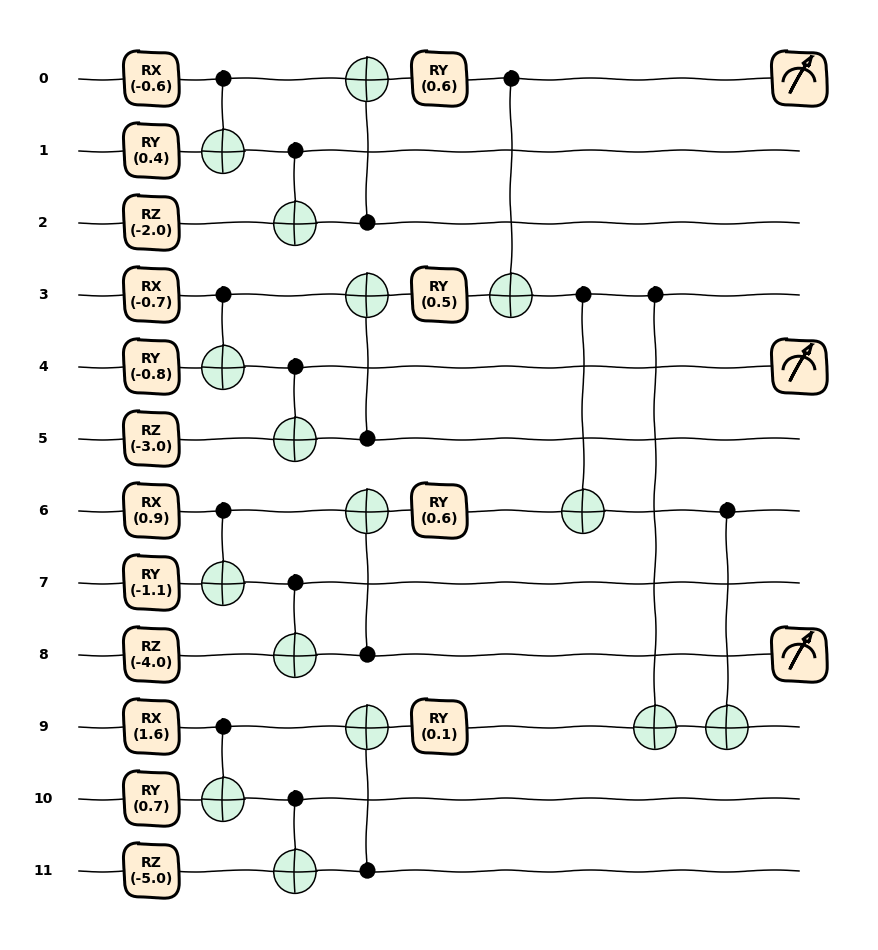

In [19]:
#For QC display
def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(3):
                if j==0:
                    qml.RX(X[i*3+j], wires = i * 3 + j)
                elif j==1:
                    qml.RY(X[i*3+j], wires = i * 3 + j)
                else:
                    qml.RZ(X[i*3+j], wires = i * 3 + j)
            #Entangle 3 positions
            qml.CNOT(wires = [i * 3, i * 3 + 1])
            qml.CNOT(wires = [i * 3 + 1, i * 3 + 2])
            qml.CNOT(wires = [i * 3 + 2, i * 3])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 3)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    qml.CNOT(wires = [i * 3, j * 3])
        return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(Nv)),qml.sample(qml.PauliZ(2*Nv))
dev = qml.device("default.qubit", wires=3*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(Xs[0],ansatz)
plt.show()

In [27]:
# Initialize a measurement quantum circuit
A=adjacency_matrix_2
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*3, shots=100)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(3):
                if j==0:
                    qml.RX(X[i*3+j], wires = i * 3 + j)
                elif j==1:
                    qml.RY(X[i*3+j], wires = i * 3 + j)
                else:
                    qml.RZ(X[i*3+j], wires = i * 3 + j)
        #Entangle 3 positions
        qml.CNOT(wires = [i * 3, i * 3 + 1])
        qml.CNOT(wires = [i * 3 + 1, i * 3 + 2])
        qml.CNOT(wires = [i * 3 + 2, i * 3])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 3)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 3, j * 3])
        return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(Nv)),qml.sample(qml.PauliZ(2*Nv))
    x = quantum_circuit(X, ansatz)
    y = [[x[0][i], x[1][i], x[2][i]] for i in range(len(x[0]))]
    return y

In [28]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*3, shots=100)
@qml.qnode(dev)
def measure(X,ansatz):
    x = quantum_circuit(X, ansatz)
    return x
def transform(x):
    y = [[x[0][i], x[1][i], x[2][i]] for i in range(100)]
    return y
def minus_to_zero(y):
    for j in range(len(y)):
        for i in range(3):
            if y[j][i]<0:
                y[j][i]=0
    return y
result=minus_to_zero(transform(measure(X,ansatz)))
#result_f=minus_to_zero(transform(measure(X_f,ansatz)))

In [29]:
#Collect measurement results from 100 samples
results=[]
for X in Xs:
    result=minus_to_zero(transform(measure(X,ansatz)))
    results.extend(result)

In [30]:
#Plotting tool
def plot_result(measurements,tf):
    # Convert each sublist in y to a binary string and create a list of binary strings
    binary_strings = [''.join(map(str, sublist)) for sublist in result]
    unique_binary_strings, counts = np.unique(binary_strings, return_counts=True)
    # Plotting the histogram
    plt.bar(unique_binary_strings, counts, edgecolor='black')
    # Adding labels and title
    plt.xlabel('Results')
    plt.ylabel('Frequency')
    if tf=='T':
        plt.title('4-qubits measurement for true 4-nodes graph')
    else:
        plt.title('4-qubits measurement for false 4-nodes graph')
    # Display the plot
    plt.show()

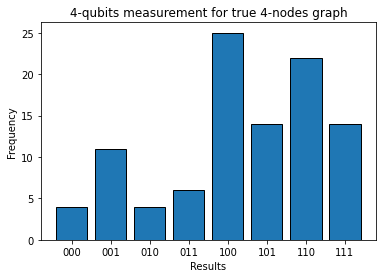

In [26]:
#Show results for the first adjacency matrix.
plot_result(results,'T')

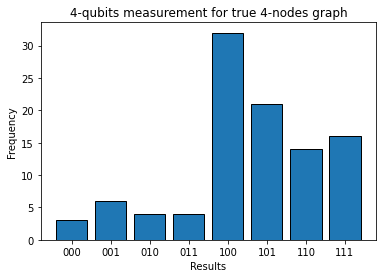

In [31]:
#Show results for different adjacency matrix.
plot_result(results,'T')